In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

%matplotlib widget
%load_ext autoreload
%autoreload 2


10.0 0.06721112132072449


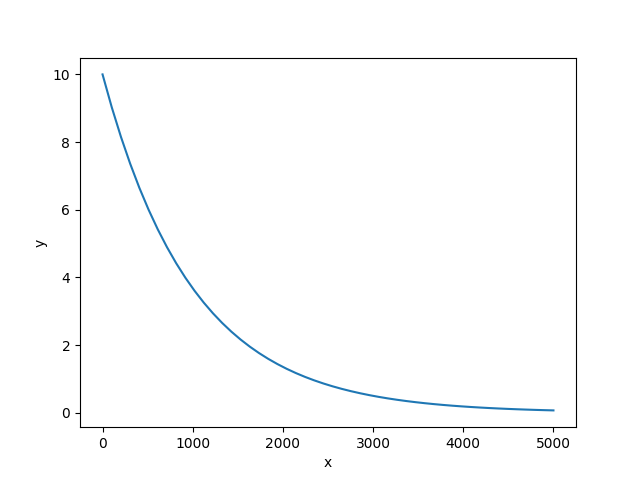

In [40]:
linspace = np.linspace(0, 5000, 50)
x = torch.tensor(linspace, requires_grad=False)
y = (10 * 0.999 ** x).float()

fig, ax = plt.subplots()
ax.plot(linspace, y.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
print(y[0].item(), y[-1].item())


In [3]:
# batch, player, position(x, y)
team = torch.tensor([[[1, 2], [3, 4]], [[7, 8], [9, 10]]]).float()
target = (1, 2)
target_torch = torch.tensor(target).repeat(team.shape[0], 1).unsqueeze(1).float()
print(team.shape, target_torch.shape)

norm = torch.norm(team - target_torch, dim=2)
print(norm)

torch.Size([2, 2, 2]) torch.Size([2, 1, 2])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])


In [4]:
torch.mean(norm, dim=1)

tensor([1.4142, 9.8995])

In [5]:
scaling = (norm)
foo = scaling * norm
foo_sum = foo.sum(dim=1).unsqueeze(1)
print(foo_sum)
print(norm)
print(norm*foo_sum)

tensor([[  8.0000],
        [200.0000]])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])
tensor([[   0.0000,   22.6274],
        [1697.0560, 2262.7415]])


In [6]:
num_frequencies = 5

freq_bands = torch.linspace(1.0, 2 ** (num_frequencies - 1), num_frequencies)
print(freq_bands)

tensor([ 1.0000,  4.7500,  8.5000, 12.2500, 16.0000])


In [7]:
nums = torch.linspace(-0.5, 0.5, 1000)

for i in range(num_frequencies):
    plt.plot(nums, torch.sin(nums * freq_bands[i]).numpy())


In [45]:
from train import train
model = train(players_per_team=1, 
        epochs=20000, 
        load_model=False,
)

Epoch [0/20000], Loss: -0.00516
Epoch [50/20000], Loss: -0.20411
Epoch [100/20000], Loss: -0.24403
Epoch [150/20000], Loss: -0.28354
Epoch [200/20000], Loss: -0.31603
Epoch [250/20000], Loss: -0.36156
Epoch [300/20000], Loss: -0.36906
Epoch [350/20000], Loss: -0.42499
Epoch [400/20000], Loss: -0.45303
Epoch [450/20000], Loss: -0.48925
Epoch [500/20000], Loss: -0.49374
Epoch [550/20000], Loss: -0.54871
Epoch [600/20000], Loss: -0.57447
Epoch [650/20000], Loss: -0.60377
Epoch [700/20000], Loss: -0.63841
Epoch [750/20000], Loss: -0.65083
Epoch [800/20000], Loss: -0.69008
Epoch [850/20000], Loss: -0.72873
Epoch [900/20000], Loss: -0.74020
Epoch [950/20000], Loss: -0.77110
Epoch [1000/20000], Loss: -0.78299
Epoch [1050/20000], Loss: -0.79586
Epoch [1100/20000], Loss: -0.81813
Epoch [1150/20000], Loss: -0.83534
Epoch [1200/20000], Loss: -0.85190
Epoch [1250/20000], Loss: -0.87001
Epoch [1300/20000], Loss: -0.86669
Epoch [1350/20000], Loss: -0.88910
Epoch [1400/20000], Loss: -0.90602
Epoch [1

15

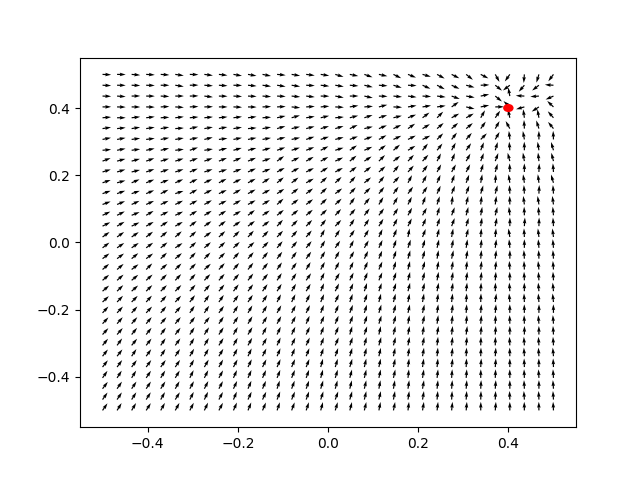

In [47]:
samples = 32
x, y = torch.meshgrid(torch.linspace(-0.5, 0.5, samples), torch.linspace(-0.5, 0.5, samples))
x = x.flatten()
y = y.flatten()
field_hight = 9000
field_width = 6000
scale = torch.tensor([field_width, field_hight]).float()

team = torch.stack([x, y], dim=1).unsqueeze(1) * scale
enemy = torch.stack([y, x], dim=1).unsqueeze(1) * scale

ball = torch.tensor([0.4, 0.4]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale

delta = model(team, enemy, ball).squeeze(1).detach().numpy()
# norm_delta = delta / torch.norm(delta, dim=1).unsqueeze(1)


fig, ax = plt.subplots()
# when a click is detected of fig, the mouse position is sent to the model
def on_mose_click(event):
    global delta
    x = event.xdata
    y = event.ydata
    # print(x, y)
    ball = torch.tensor([x, y]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale
    # old_delta = delta.copy()
    delta = model(team, enemy, ball).squeeze(1).detach().numpy()
    # print(np.linalg.norm(delta - old_delta))
    ax.clear()
    
    ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
    circle = plt.Circle((x, y), 0.01, color='r')
    ax.add_artist(circle)
    fig.canvas.draw()


ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
circal = plt.Circle(ball[0, 0]/scale, 0.01, color='r')
ax.add_artist(circal)
fig.canvas.mpl_connect('button_press_event', on_mose_click)


